Multi Armed slot machine problem - Multi-Amred Bandits, MAB   

Yujin Lee (proqk) - 2021.06.23   
참고 책: 알파제로를 분석하며 배우는 인공지능

Select the arm of the slot machine to gather information (exploration) + Choose the arm with the highest reward (exploitation)   
정보 수집을 위해 슬롯머신의 팔을 선택한다 (탐색) + 보상이 가장 높은 팔을 선택한다 (이용)

In [1]:
import numpy as np
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Make slot arm
class SlotArm():
  def __init__(self, p):
    self.p = p #Probability of getting a coin
  
  #Get a reward for choosing an arm
  def draw(self):
    if self.p > random.random():
      return 1.0
    else:
      return 0.0

Epsilon-Greedy - Balance exploration and exploitation   

1. initialize   
Randomly selects an action with E probability (0<=E<=1 integer), and selects an action with the maximum initial reward with 1-E probability.   
Returns the arm number.

  Epsilon-Greedy - 탐색과 이용의 균형을 잡는 방법   
E 확률(0 이상 1이하의 정수)로 랜덤하게 행동을 선택, 1-E 확률로 초기 보상이 최대가 되는 행동을 선택한다.   
팔의 번호를 반환한다.

2. update   
update parameter: (1) +1 number of attempts of the selected arm (2) update the value of the selected arm   

  파라미터를 다음 순서에 따라 갱신한다: (1) 선택한 팔의 시행 횟수+1 (2) 선택한 팔의 가치 갱신   
  선택한 팔의 가치(평균 보상)는 수식에 따라 갱신한다.   
  (이번 시행의 가치:평균 보상) = (시행횟수-1)/(시행횟수) * (이전 시행의 가치 :평균 보상) + 1/시행횟수 * (이번 시행의 보상)

In [3]:
#Calculation epsilon-Greedy
class EpsilonGreedy():
  #init e-greedy
  def __init__(self, epsilon):
    self.epsilon = epsilon #Probability of exploration

  #init n, v (n_arms: number of arms)
  def initialize(self, n_arms): 
    self.n = np.zeros(n_arms) #number of attempts for each arm - list
    self.v = np.zeros(n_arms) #value of each arm - list (평균보상)

  #Select arm
  def select_arm(self):
    if self.epsilon > random.random():
      return np.random.randint(0, len(self.v)) #select random
    else:
      return np.argmax(self.v) #select high value arm

  #Update parameter
  def update(self, chosen_arm, reward, t):
    self.n[chosen_arm] += 1 #attempts of the selected arm + 1

    #update the value of the selected arm
    n = self.n[chosen_arm]
    v = self.v[chosen_arm]
    self.v[chosen_arm] = ((n-1) / float(n)) * v + (1 / float(n)) * reward

  #string info
  def label(self):
    return 'E-greedy('+str(self.epsilon)+')'

UCB1(Upper Confidence Bound1) - Balance exploration and exploitation   

1. initialize   
UCB1 is a method of selecting the action that maximizes the 'success rate + bias'. The success rate is 'the number of successful actions/the number of attempts of the action'. The bias is the 'distribution size of the success rate by chance'. The smaller the number of attempts of the action, the greater it becomes.

  UCB1 - 탐색과 이용의 균형을 잡는 방법   
'성공률+바이어스(편향)'를 최대로 만드는 행동을 선택하는 방법이다. 성공률은 '해당 행동의 성공 횟수/해당 행동의 시행 횟수'이다. 편향은 '우연에 의한 성공률의 분포 크기'로 해당 행동의 시행 횟수가 작을수록 커진다.

2. update   
update parameter: (1) the number of attempts of the selected arm +1 (2) on success, the number of successes of the selected arm +1 (3) value is not updated if there is an arm with the number of attempts 0 (not divided by zero) (4) Calculate the value of each arm

  파라미터를 다음 순서에 따라 갱신한다: (1) 선택한 팔의 시행 횟수+1 (2) 성공 시, 선택한 팔의 성공 횟수+1 (3) 시행 횟수가 0인 팔이 존재하는 경우 가치를 갱신하지 않음(0 나누기 불가) (4) 각 팔의 가치 계산 

In [4]:
#UCB1
class UCB1():
  def initialize(self, n_arms):
    self.n = np.zeros(n_arms) #number of attempts of each arm
    self.w = np.zeros(n_arms) #number of successes of each arm
    self.v = np.zeros(n_arms) #value of each arm
  
  #select arm
  def select_arm(self):
    #select arms that all n>=1 
    for i in range(len(self.n)):
      if self.n[i] == 0:
        return i
    return np.argmax(self.v) #select high value arm

  #update parameter
  def update(self, chosen_arm, reward, t):
    self.n[chosen_arm] += 1 #attempts of the selected arm + 1

    if reward == 1.0:
      self.w[chosen_arm] += 1 #if success, successes of the selected arm + 1

    #if there is an arm with the number of attempts 0, value is not updated 
    for i in range(len(self.n)):
      if self.n[i] == 0:
        return
    
    #update the value of each arms
    for i in range(len(self.v)):
      self.v[i] = self.w[i] / self.n[i] + (2*math.log(t) / self.n[i]) ** 0.5

  #string info
  def label(self):
    return 'ucb1'

In [5]:
#run
def play(algo, arms, num_sims,num_time):
  times = np.zeros(num_sims*num_time) #game times
  rewards = np.zeros(num_sims*num_time) #rewards

  #roop simulation
  for sim in range(num_time):
    algo.initialize(len(arms))

    #roop game
    for time in range(num_time):
      #calculate index
      index = sim * num_time + time

      times[index] = time + 1
      chosen_arm = algo.select_arm()
      reward = arms[chosen_arm].draw()
      rewards[index] = reward

      #update parameter
      algo.update(chosen_arm, reward, time+1)

  return [times, rewards]

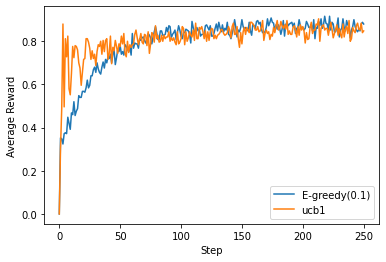

In [6]:
#select arm
arms = (SlotArm(0.3), SlotArm(0.5), SlotArm(0.9))

#set algorithm
algos = (EpsilonGreedy(0.1), UCB1())

#run
for algo in algos:
  result = play(algo, arms, 1000, 250)

  #draw graph
  df = pd.DataFrame({'times': result[0], 'rewards': result[1]})
  mean = df['rewards'].groupby(df['times']).mean()
  plt.plot(mean, label = algo.label())

plt.xlabel('Step')
plt.ylabel('Average Reward')
plt.legend(loc = 'best')
plt.show()